### KDD Process (ricordare cosa dobbiamo fare (indicate dal prof))
1. Dataset load and features semantics
1. Data Cleaning (handle missing values, remove useless variables)
1. Feature Engineering
1. Classification Preprocessing (feature reshaping, train/test partitioning)
1. Parameter Tuning
1. Perform Classification
1. Analyze the classification results
1. Analyze the classification performance
1. Can we improve the performance using another classifier?

In [1]:
import matplotlib.pylab as plt
import numpy as np
import pandas as pd

from scipy.stats import chi2_contingency
from sklearn.preprocessing import LabelEncoder

### Dataset load and features semantics

In [2]:
# load the dataset
df = pd.read_csv("data/telecom_users.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5986 entries, 0 to 5985
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0        5986 non-null   int64  
 1   customerID        5986 non-null   object 
 2   gender            5986 non-null   object 
 3   SeniorCitizen     5986 non-null   int64  
 4   Partner           5986 non-null   object 
 5   Dependents        5986 non-null   object 
 6   tenure            5986 non-null   int64  
 7   PhoneService      5986 non-null   object 
 8   MultipleLines     5986 non-null   object 
 9   InternetService   5986 non-null   object 
 10  OnlineSecurity    5986 non-null   object 
 11  OnlineBackup      5986 non-null   object 
 12  DeviceProtection  5986 non-null   object 
 13  TechSupport       5986 non-null   object 
 14  StreamingTV       5986 non-null   object 
 15  StreamingMovies   5986 non-null   object 
 16  Contract          5986 non-null   object 


- ``customerID``- customer id;
- ``gender`` - client gender (male / female)
- ``SeniorCitizen`` - is the client retired (1, 0)
- ``Partner`` - is the client married (Yes, No)
- ``Dependents`` - has dependents (Yes, No)
- ``tenure`` - how many months a person has been a client of the company
- ``PhoneService`` - is the telephone service connected (Yes, No)
- ``MultipleLines`` - are multiple phone lines connected (Yes, No, No phone service)
- ``InternetService`` - client's Internet service provider (DSL, Fiber optic, No)
- ``OnlineSecurity`` - is the online security service connected (Yes, No, No internet service)
- ``OnlineBackup`` - is the online backup service activated (Yes, No, No internet service)
- ``DeviceProtection`` - does the client have equipment insurance (Yes, No, No internet service)
- ``TechSupport`` - is the technical support service connected (Yes, No, No internet service)
- ``StreamingTV`` - is the streaming TV service connected (Yes, No, No internet service)
- ``StreamingMovies`` - is the streaming cinema service activated (Yes, No, No internet service)
- ``Contract`` - type of customer contract (Month-to-month, One year, Two year)
- ``PaperlessBilling`` - whether the client uses paperless billing (Yes, No)
- ``PaymentMethod`` - payment method (Electronic check, Mailed check, Bank transfer (automatic), Credit card (automatic))
- ``MonthlyCharges`` - current monthly payment
- ``TotalCharges`` - the total amount that the client paid for the services for the entire time
- ``Churn`` - whether there was a churn (Yes or No)

## Data cleaning

TotalCharges: In this column there were 10 missing values. Analyzing this records we have noticed that in all of them 'tenure' was zero, so new customers that haven't done still the first payment. So we decided to fill TotalCharges with 0.

In [3]:
# Setting total charges for new customers.
df['TotalCharges'] = np.where(df['tenure'] == 0, 0, df['TotalCharges'])
df['TotalCharges'] = df['TotalCharges'].astype(float)

df.drop('Unnamed: 0', axis=1, inplace=True)  # Remove useless column.

# Encoding categorical attributes.
encoders = dict()
classes = list()
attributes = list()

attributes.append(['Partner', 'Dependents', 'PhoneService', 'Churn', 'PaperlessBilling'])
classes.append(['No', 'Yes'])

attributes.append(['MultipleLines'])
classes.append(['No', 'Yes', 'No phone service'])

attributes.append(['InternetService'])
classes.append(['No', 'DSL', 'Fiber optic'])

attributes.append(['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies'])
classes.append(['No', 'Yes', 'No internet service'])

attributes.append(['Contract'])
classes.append(['Month-to-month', 'One year', 'Two year'])

attributes.append(['PaymentMethod'])
classes.append(['Electronic check', 'Mailed check', 'Bank transfer (automatic)', 'Credit card (automatic)'])

for attribute_list, class_list in zip(attributes, classes):
    for attribute in attribute_list:
        encoder = LabelEncoder().fit(df[attribute])
        encoder.classes_ = class_list
        df[attribute] = encoder.transform(df[attribute])
        encoders[attribute] = encoder

### Feature Engineering

In [4]:
# Average monthly charges.
df['AvgMonthlyCharges'] = np.where(df['tenure'] == 0, 
                                   df['TotalCharges'],
                                   df['TotalCharges'] / df['tenure']).round(decimals=2)

# Compute number of active services.
df['Nservices'] = (df[df.columns[6:15]] == 'Yes').sum(axis=1)

# InternetService is not Yes or No, but it has 3 values.
df['Nservices'] = np.where(df['InternetService'] == 'No', df['Nservices'], df['Nservices'] + 1)

# Difference between current monthly charge and the average for each customer.
df['Difference'] = (df['AvgMonthlyCharges'] - df['MonthlyCharges']).round(decimals=2)

# Moving Churn to last position.
churn = df.pop('Churn')
df.insert(len(df.columns), 'Churn', churn)

- Phone service implies MultipleLines
- InternetService implies OtherServices

## Exploratory Analysis 

In [5]:
df.describe()

,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,...,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,AvgMonthlyCharges,Nservices,Difference,Churn
count,5986.000000,5986.000000,5986.000000,5986.000000,5986.000000,5986.000000,5986.000000,5986.000000,5986.000000,5986.000000,...,5986.000000,5986.000000,5986.000000,5986.000000,5986.000000,5986.000000,5986.000000,5986.0,5986.000000,5986.000000
mean,0.161377,0.485132,0.299198,32.468760,0.901437,0.622787,1.223187,0.717508,0.780488,0.774641,...,0.822085,0.694621,0.589375,1.318744,64.802213,2294.221559,64.735672,1.0,-0.066542,0.265119
std,0.367909,0.499821,0.457945,24.516391,0.298100,0.657360,0.777699,0.796327,0.776381,0.778469,...,0.760064,0.832884,0.491988,1.150194,30.114702,2274.164124,30.309495,0.0,3.174004,0.441433
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,18.250000,0.000000,0.000000,1.0,-80.850000,0.000000
25%,0.000000,0.000000,0.000000,9.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,35.650000,401.587500,35.917500,1.0,-1.130000,0.000000
50%,0.000000,0.000000,0.000000,29.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,0.000000,1.000000,1.000000,70.400000,1408.575000,70.450000,1.0,0.000000,0.000000
75%,0.000000,1.000000,1.000000,56.000000,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,2.000000,89.900000,3841.500000,90.290000,1.0,1.160000,1.000000
max,1.000000,1.000000,1.000000,72.000000,1.000000,2.000000,2.000000,2.000000,2.000000,2.000000,...,2.000000,2.000000,1.000000,3.000000,118.750000,8684.800000,121.400000,1.0,18.900000,1.000000


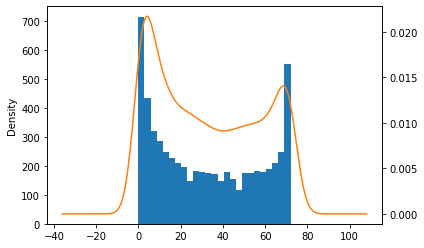

In [6]:
df['tenure'].plot(kind='hist', bins=25)
df['tenure'].plot(kind='kde', secondary_y=True);

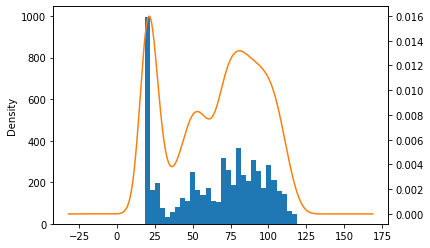

In [7]:
df['MonthlyCharges'].plot(kind='hist', bins=30)
df['MonthlyCharges'].plot(kind='kde', secondary_y=True);

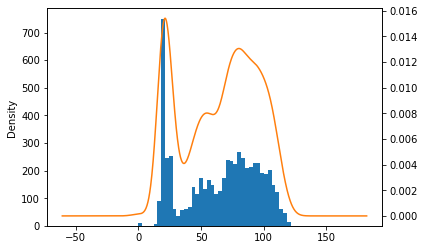

In [8]:
df['AvgMonthlyCharges'].plot(kind='hist', bins=40)
df['AvgMonthlyCharges'].plot(kind='kde', secondary_y=True);

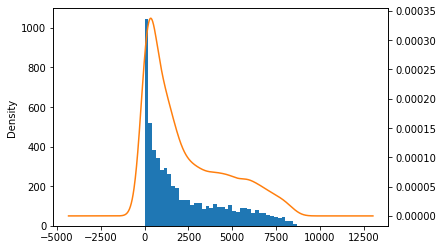

In [9]:
df['TotalCharges'].plot(kind='hist', bins=40)
df['TotalCharges'].plot(kind='kde', secondary_y=True);

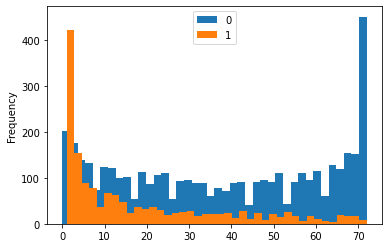

In [10]:
df.groupby(['Churn']).tenure.plot(kind='hist', bins=40)
plt.legend()
plt.show()

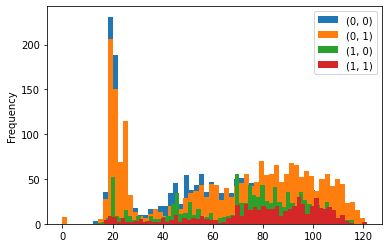

In [11]:
df.groupby(['Churn', 'Partner']).AvgMonthlyCharges.plot(kind='hist', bins=60)
plt.legend()
plt.show()

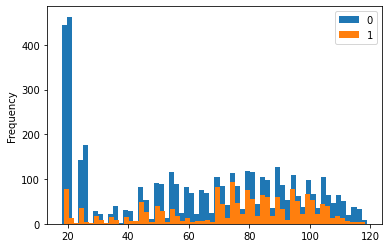

In [12]:
ax = df.groupby(['Churn']).MonthlyCharges.plot(kind='hist', bins=60)
plt.legend()
plt.show()

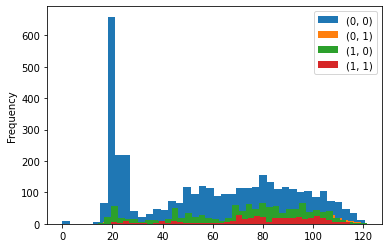

In [13]:
df.groupby(['Churn', 'SeniorCitizen']).AvgMonthlyCharges.plot(kind='hist', bins=40)
plt.legend()
plt.show()

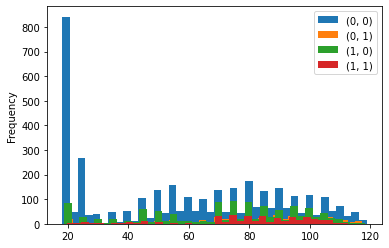

In [14]:
df.groupby(['Churn', 'SeniorCitizen']).MonthlyCharges.plot(kind='hist', bins=40)
plt.legend()
plt.show()

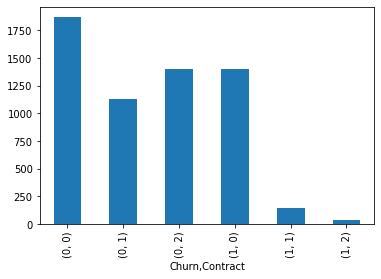

In [15]:
ax = df.groupby(['Churn', 'Contract']).Contract.count().plot(kind='bar')
plt.show()

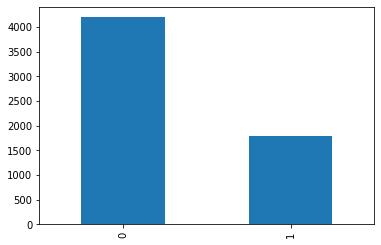

In [16]:
df['Dependents'].value_counts().plot(kind='bar');

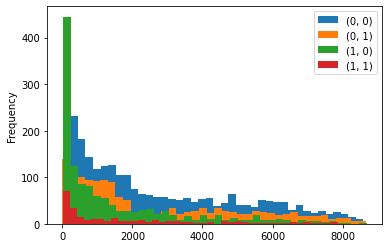

In [17]:
df.groupby(['Churn', 'Dependents']).TotalCharges.plot(kind='hist', bins=40)
plt.legend()
plt.show()

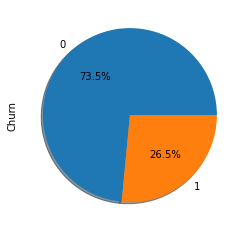

In [18]:
df.Churn.value_counts().plot(kind='pie', autopct='%1.1f%%', shadow=True, startangle=0);

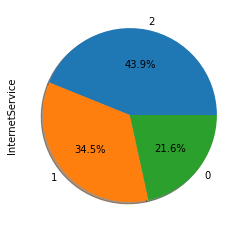

In [19]:
df.InternetService.value_counts().plot(kind='pie', autopct='%1.1f%%', shadow=True, startangle=0);

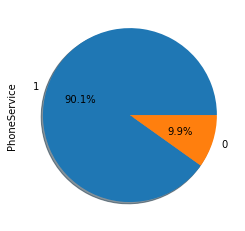

In [20]:
df.PhoneService.value_counts().plot(kind='pie', autopct='%1.1f%%', shadow=True, startangle=0);

In [21]:
pd.crosstab(df.StreamingTV, df.StreamingMovies)

StreamingMovies,0,1,2
StreamingTV,,,
0,1710,679,0
1,646,1660,0
2,0,0,1291


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=4e898cb9-a57f-4e4f-afd9-b8a3b338d9dd' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>